# 1. VHM Dataset

In [162]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [163]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)
df1

0       68421.0
1       70075.0
2       68421.0
3       69022.0
4       69173.0
         ...   
1247    43350.0
1248    44200.0
1249    44400.0
1250    43400.0
1251    43950.0
Name: Price, Length: 1252, dtype: float64

In [164]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [165]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [166]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [167]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [168]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [169]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [170]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 42ms/step - loss: 0.0506 - val_loss: 0.0116
Epoch 2/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 4/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 9.0200e-04
Epoch 8/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 8.7836e-04
Epoch 9/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 9.4865e-04
Epoch 10/100
17/17 [==============================] - 1s 41ms/step - loss: 9.7918e-04 - 

In [171]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 23ms/step


In [172]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [173]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 43016.516732074735
Testing MAPE: 533620.1588949595
Testing MAE: 42989.30211807766


In [174]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

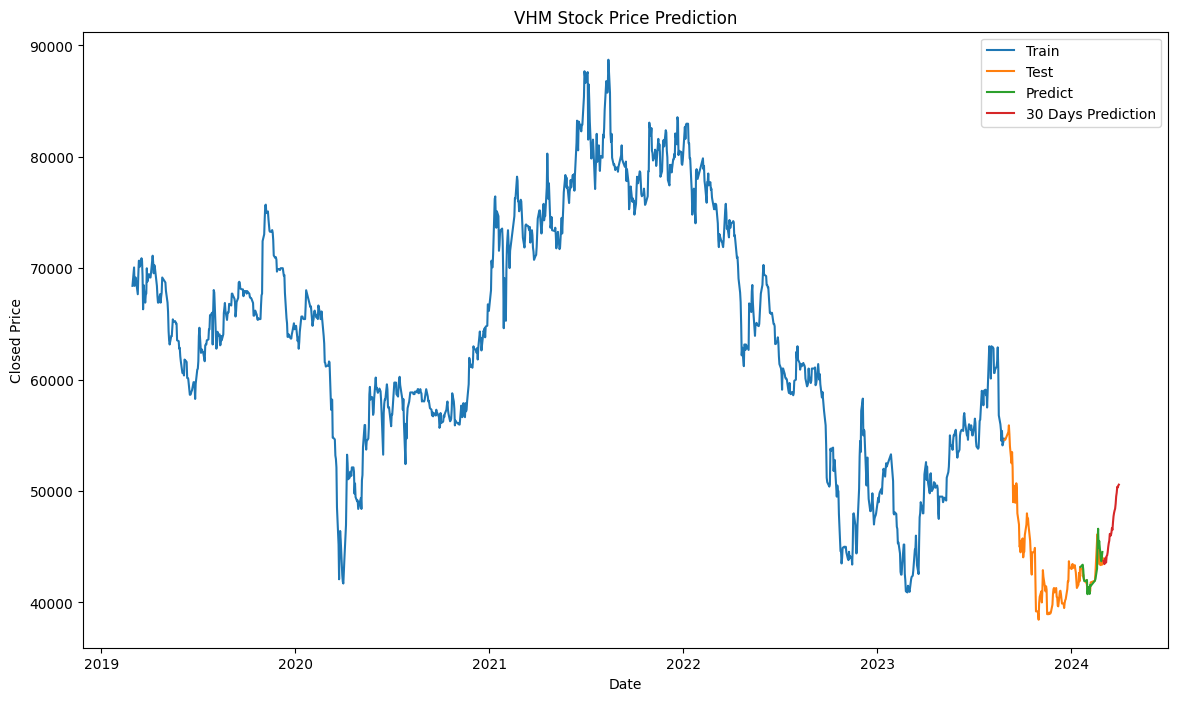

In [175]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [176]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [177]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [178]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [179]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [180]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [181]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 37ms/step - loss: 0.0301 - val_loss: 0.0067
Epoch 2/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 3/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 5/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 6/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 7/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 8/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/100
15/15 [==============================] - 0s 30ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 10/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 0.0023

In [182]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [183]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [184]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 46862.21209990175
Testing MAPE: 1.199718830547987e+18
Testing MAE: 46309.0890855579


In [185]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

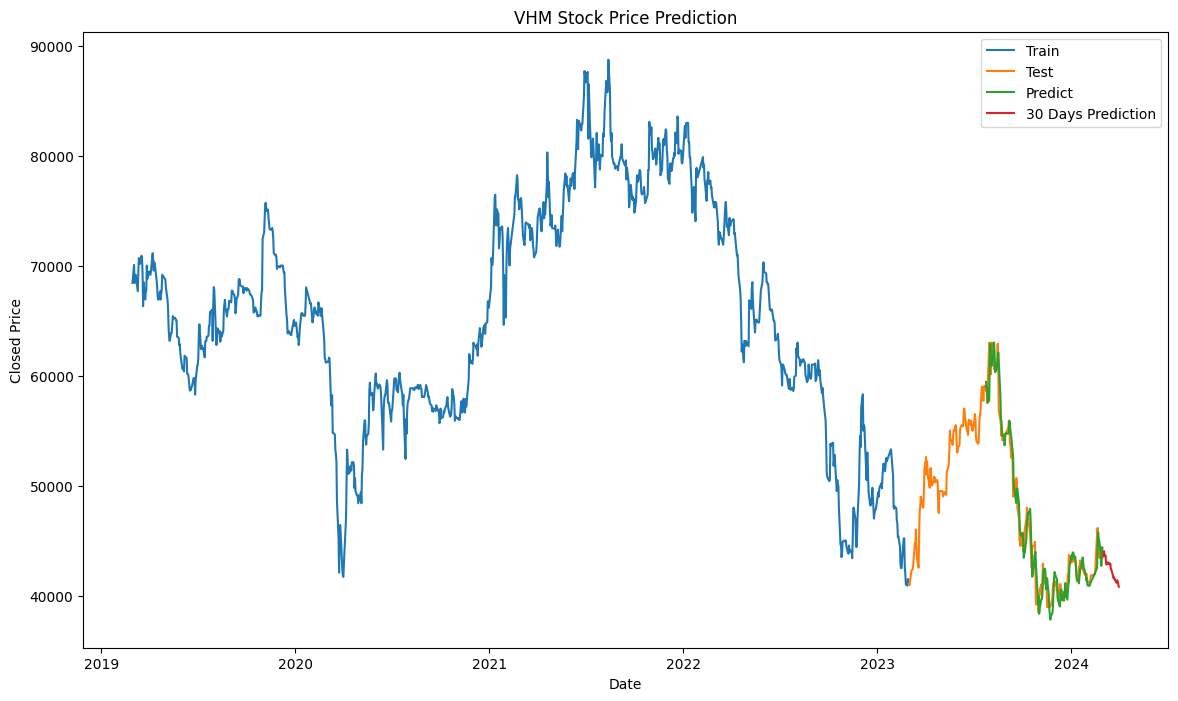

In [186]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [187]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [188]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [189]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [190]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [191]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [192]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 70ms/step - loss: 0.1764 - val_loss: 0.0377
Epoch 2/100
13/13 [==============================] - 1s 75ms/step - loss: 0.0215 - val_loss: 0.0253
Epoch 3/100
13/13 [==============================] - 0s 29ms/step - loss: 0.0104 - val_loss: 0.0131
Epoch 4/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 5/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 6/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 7/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 8/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0067 - val_loss: 0.0099
Epoch 9/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 10/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0049

In [193]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 6ms/step


In [194]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [195]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 49170.52805979469
Testing MAPE: 6.661095728124809e+17
Testing MAE: 48768.85801460058


In [196]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

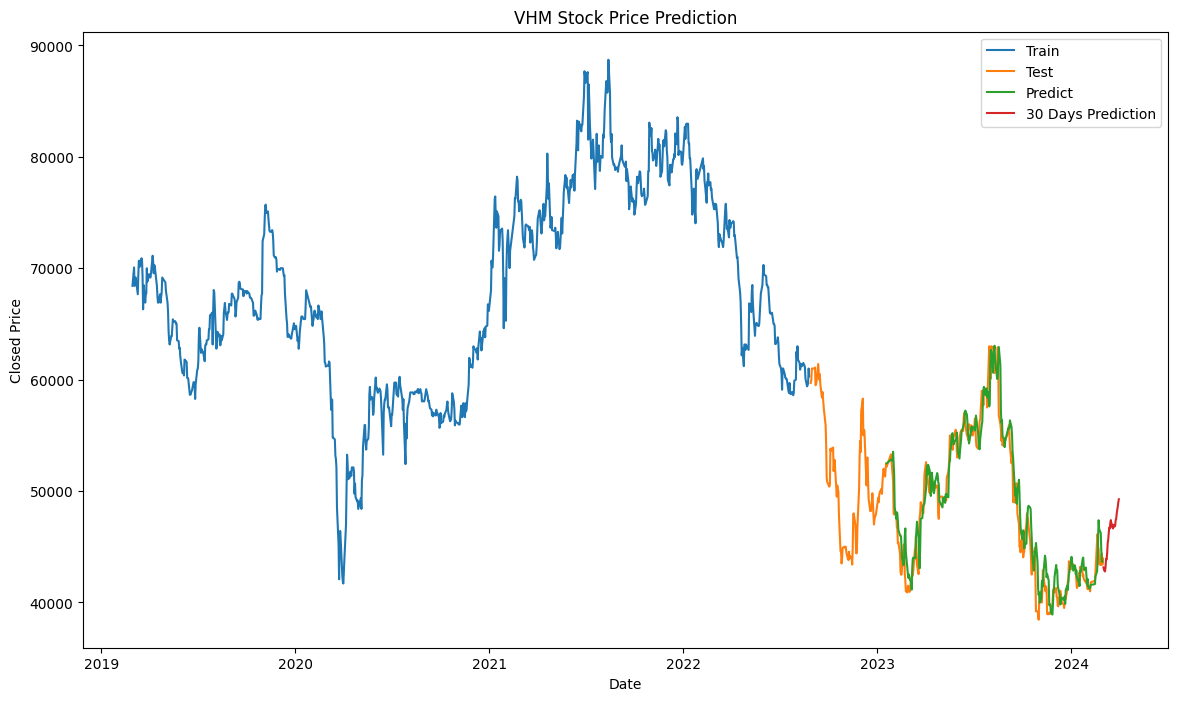

In [197]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

# 2. NVL Dataset

In [198]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [199]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)
df1

0       32933.0
1       33100.0
2       32711.0
3       31709.0
4       31932.0
         ...   
1247    16800.0
1248    17050.0
1249    17000.0
1250    17100.0
1251    17300.0
Name: Price, Length: 1252, dtype: float64

In [200]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [201]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [202]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [203]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [204]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [205]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [206]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 35ms/step - loss: 0.0988 - val_loss: 0.0015
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 3.0161e-04
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 8.6860e-05
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 6.2865e-05
Epoch 5/100
17/17 [==============================] - 0s 22ms/step - loss: 8.9462e-04 - val_loss: 6.7599e-05
Epoch 6/100
17/17 [==============================] - 0s 19ms/step - loss: 8.4811e-04 - val_loss: 9.6179e-05
Epoch 7/100
17/17 [==============================] - 0s 20ms/step - loss: 8.0195e-04 - val_loss: 8.5125e-05
Epoch 8/100
17/17 [==============================] - 0s 21ms/step - loss: 7.7313e-04 - val_loss: 1.8846e-04
Epoch 9/100
17/17 [==============================] - 0s 19ms/step - loss: 8.2051e-04 - val_loss: 1.4265e-04
Epoch 10/100
17/17 [============================

In [207]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 23ms/step


In [208]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [209]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 16294.376324267245
Testing MAPE: 198889.44905715977
Testing MAE: 16287.824835052317


In [210]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

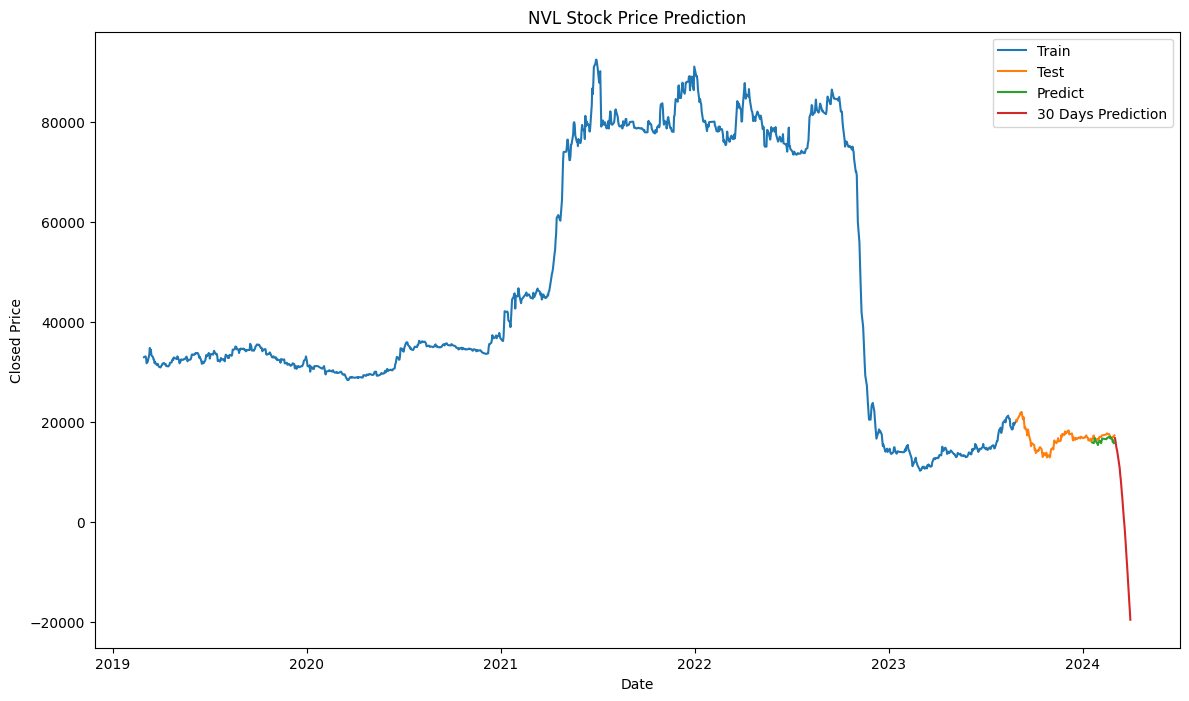

In [211]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [212]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [213]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [214]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [215]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [216]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [217]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 39ms/step - loss: 0.0172 - val_loss: 6.6835e-04
Epoch 2/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/100
15/15 [==============================] - 0s 20ms/step - loss: 7.6589e-04 - val_loss: 2.8996e-04
Epoch 4/100
15/15 [==============================] - 0s 24ms/step - loss: 6.1319e-04 - val_loss: 2.7801e-04
Epoch 5/100
15/15 [==============================] - 1s 35ms/step - loss: 5.5489e-04 - val_loss: 2.4828e-04
Epoch 6/100
15/15 [==============================] - 1s 43ms/step - loss: 5.2608e-04 - val_loss: 2.3586e-04
Epoch 7/100
15/15 [==============================] - 1s 39ms/step - loss: 4.9598e-04 - val_loss: 2.0646e-04
Epoch 8/100
15/15 [==============================] - 1s 39ms/step - loss: 6.1946e-04 - val_loss: 2.0193e-04
Epoch 9/100
15/15 [==============================] - 1s 40ms/step - loss: 4.8955e-04 - val_loss: 2.1193e-04
Epoch 10/100
15/15 [====================

In [218]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [219]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [220]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 16884.152608605564
Testing MAPE: 215982.6968035465
Testing MAE: 16749.53329678791


In [221]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

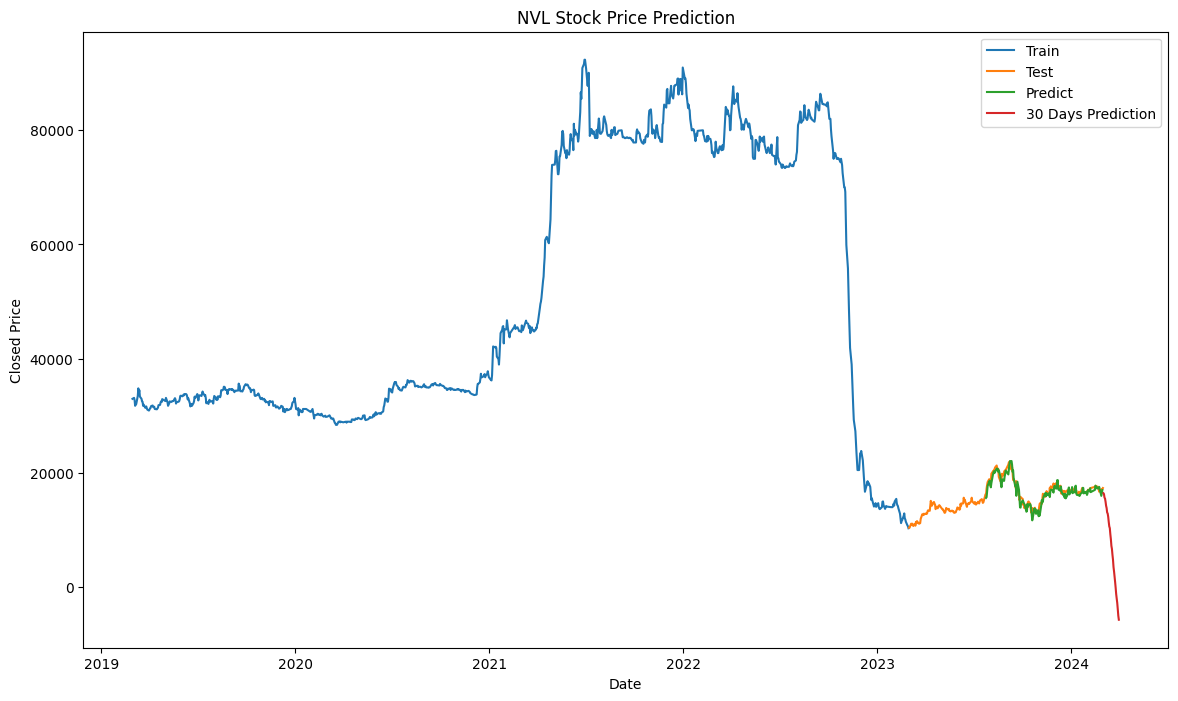

In [222]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [223]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [224]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [225]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [226]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [227]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [228]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 58ms/step - loss: 0.3349 - val_loss: 0.0082
Epoch 2/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 3/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 4/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 5/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 6/100
13/13 [==============================] - 0s 22ms/step - loss: 9.5094e-04 - val_loss: 0.0029
Epoch 7/100
13/13 [==============================] - 0s 22ms/step - loss: 8.9327e-04 - val_loss: 0.0029
Epoch 8/100
13/13 [==============================] - 0s 25ms/step - loss: 8.8374e-04 - val_loss: 0.0028
Epoch 9/100
13/13 [==============================] - 0s 22ms/step - loss: 9.0612e-04 - val_loss: 0.0026
Epoch 10/100
13/13 [==============================] - 0s 23ms/step - loss: 8.8066e-0

In [229]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 6ms/step


In [230]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [231]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 18268.570292781358
Testing MAPE: 2.4402169240947402e+17
Testing MAE: 18102.08384233785


In [232]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

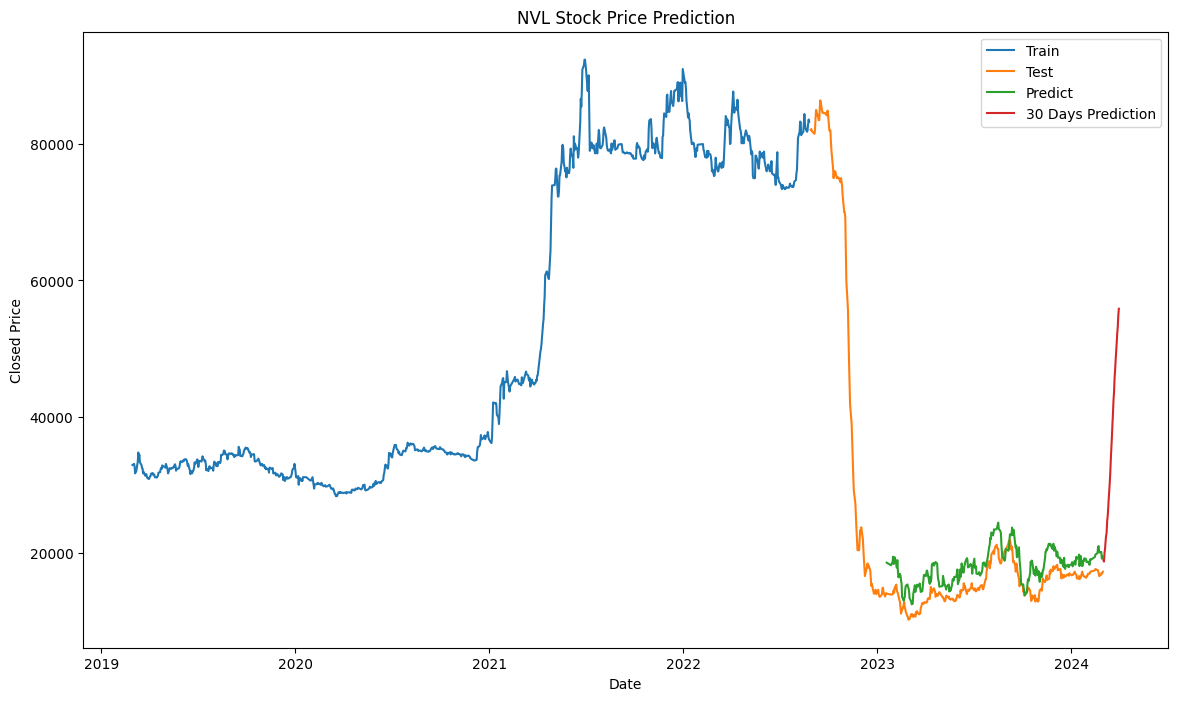

In [233]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

# 3. NLG Dataset

In [234]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [235]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)
df1

0       18706.8
1       19127.2
2       18917.0
3       18846.9
4       18706.8
         ...   
1247    37400.0
1248    38500.0
1249    38200.0
1250    39600.0
1251    39900.0
Name: Price, Length: 1252, dtype: float64

In [236]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [237]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [238]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [239]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [240]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [241]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [242]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 56ms/step - loss: 0.0118 - val_loss: 5.1063e-04
Epoch 2/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0025 - val_loss: 4.4058e-04
Epoch 3/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0020 - val_loss: 4.7964e-04
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0015 - val_loss: 8.6001e-04
Epoch 5/100
17/17 [==============================] - 1s 31ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 7.8143e-04
Epoch 7/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 3.1377e-04
Epoch 9/100
17/17 [==============================] - 0s 21ms/step - loss: 9.8645e-04 - val_loss: 2.9889e-04
Epoch 10/100
17/17 [==============================] - 0s 20ms/step -

In [243]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 42ms/step


In [244]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [245]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 38618.40853803739
Testing MAPE: 77677.75775823435
Testing MAE: 38614.088152827855


In [246]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

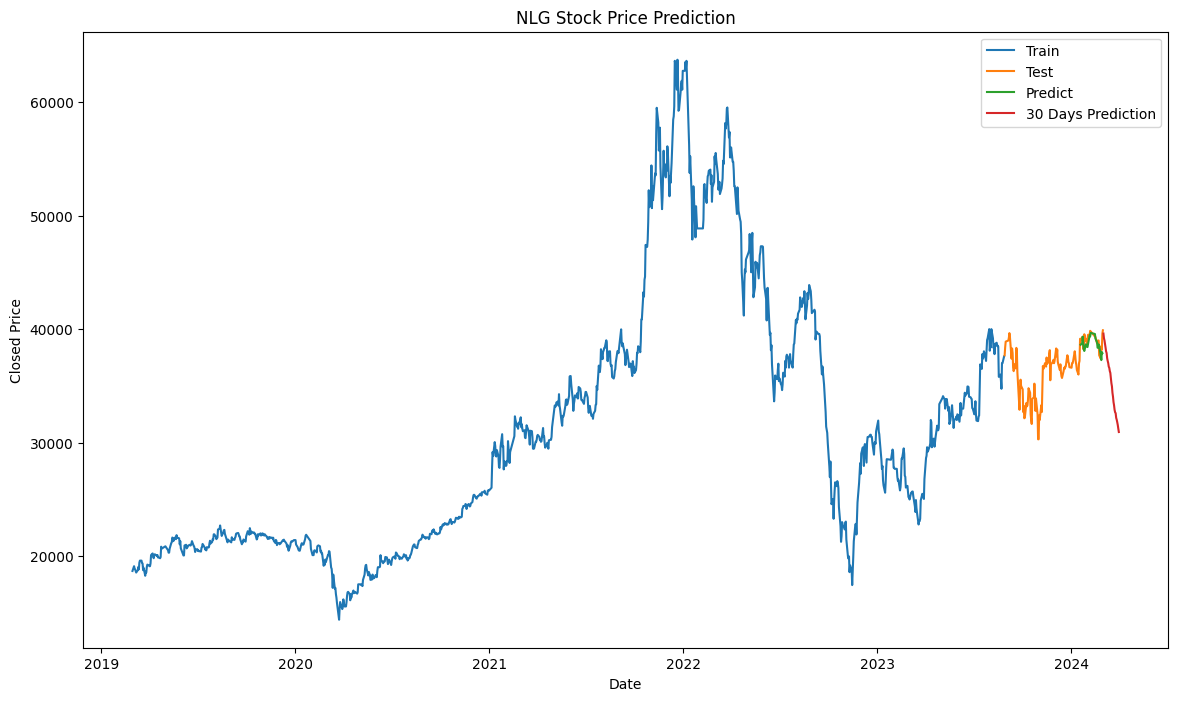

In [247]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [248]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [249]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [250]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [251]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [252]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [253]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 37ms/step - loss: 0.0182 - val_loss: 0.0031
Epoch 2/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/100
15/15 [==============================] - 0s 20ms/step - loss: 9.8615e-04 - val_loss: 0.0011
Epoch 4/100
15/15 [==============================] - 0s 21ms/step - loss: 8.9548e-04 - val_loss: 7.3436e-04
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 8.9442e-04 - val_loss: 7.3270e-04
Epoch 6/100
15/15 [==============================] - 0s 22ms/step - loss: 8.8505e-04 - val_loss: 9.7461e-04
Epoch 7/100
15/15 [==============================] - 0s 21ms/step - loss: 8.8662e-04 - val_loss: 7.3787e-04
Epoch 8/100
15/15 [==============================] - 0s 22ms/step - loss: 8.2830e-04 - val_loss: 7.2378e-04
Epoch 9/100
15/15 [==============================] - 0s 20ms/step - loss: 8.1708e-04 - val_loss: 7.9155e-04
Epoch 10/100
15/15 [============================

In [254]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 6ms/step


In [255]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [256]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 37009.71878687937
Testing MAPE: 81864.15752183904
Testing MAE: 36941.43288869179


In [257]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

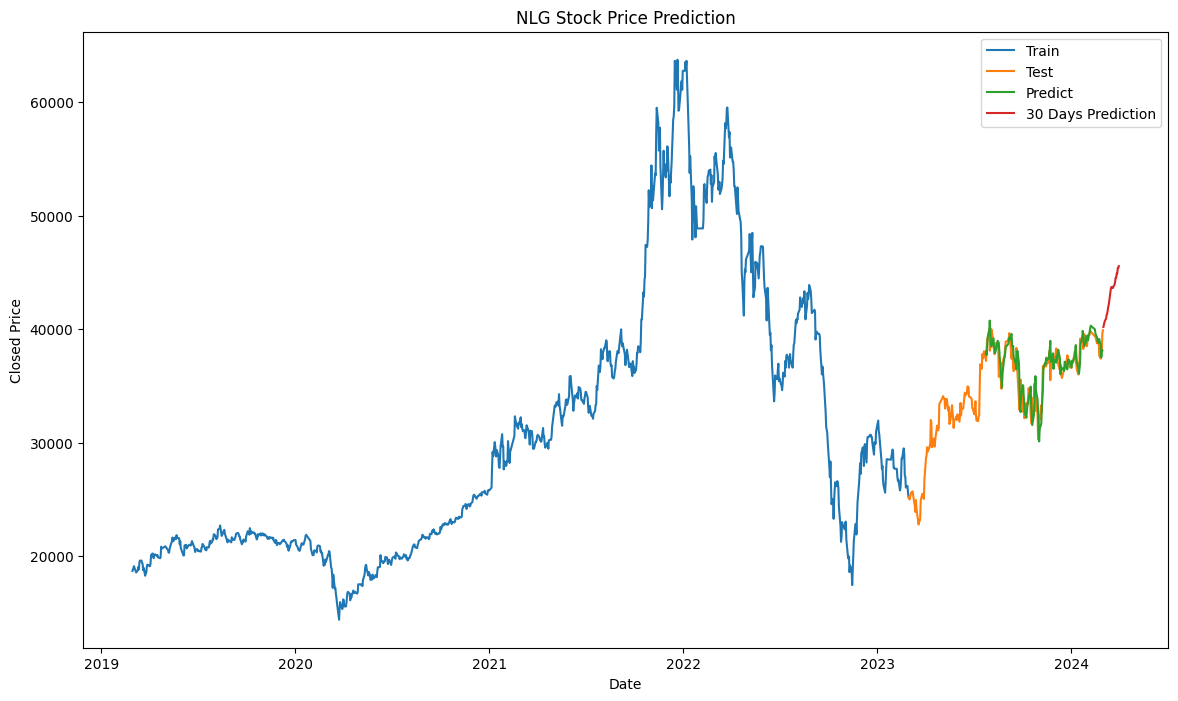

In [258]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [259]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [260]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [261]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [262]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [263]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [264]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0615 - val_loss: 0.0018
Epoch 2/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 3/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 4/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0014 - val_loss: 0.0015

In [265]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 6ms/step


In [266]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [267]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 34035.31465080868
Testing MAPE: 88339.28333962838
Testing MAE: 33745.03073110109


In [268]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

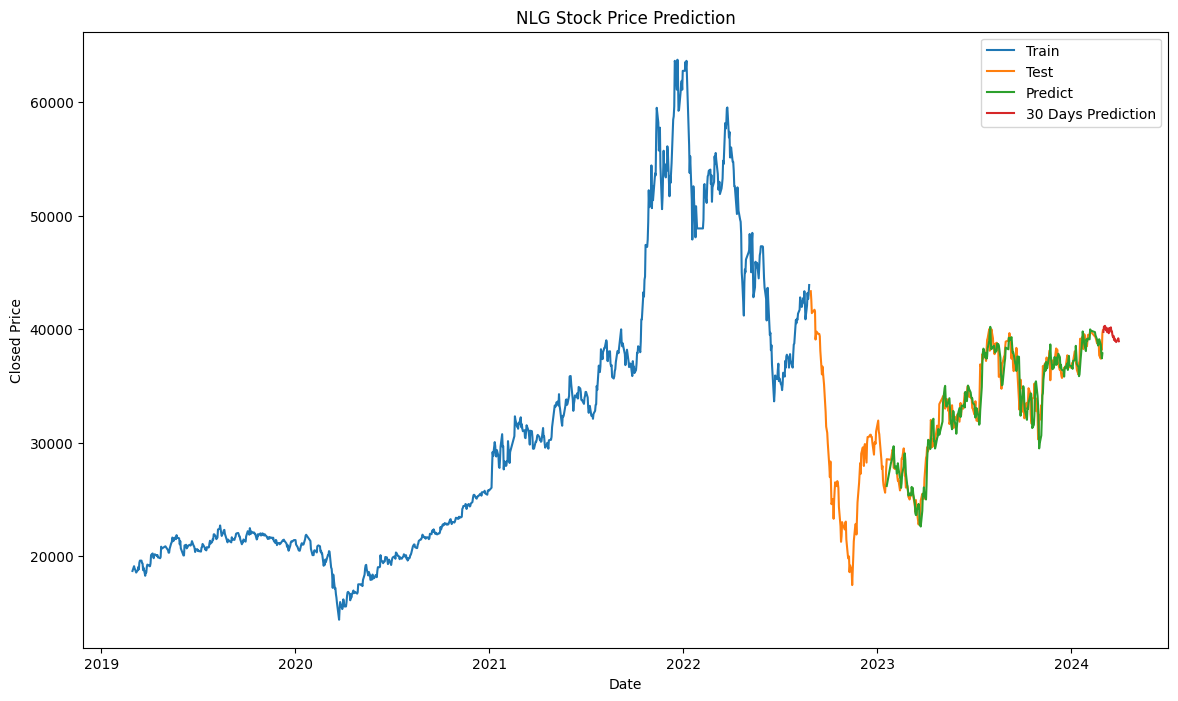

In [269]:
# 14.Vẽ hình

plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()